# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
import requests
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Paso 2: Descargar HTML

In [2]:
url = "https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_y_territorios_dependientes_por_poblaci%C3%B3n"
respuesta = requests.get(url)
contenido_html = respuesta.text

In [3]:
respuesta.status_code

200

## Paso 3: Transformar el HTML

In [4]:
tablas = pd.read_html(contenido_html)
print(f"Número de tablas encontradas: {len(tablas)}")
df_raw = tablas[0]
df_raw.head()

Número de tablas encontradas: 7


/tmp/ipykernel_3382/1223489016.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tablas = pd.read_html(contenido_html)


,N.º,País (o territorio dependiente),Proyección exponencial de la población al 1/7/2025[7]​,Total mun- dial (%),Cambio medio anual (%)[8]​,Cambio absoluto anual promedio,Cambio medio abs. total anual (%),Años para even- tual du- pli- ca- ción[9]​,"Censo más reciente, última estimación oficial, proyección de la ONU o reloj de población nacional",Fecha de esta última cifra de población en particular (d/mm/aaaa)[10]​,Tipo[11]​,Enlace o hipervínculo (usualmente de tipo oficial) de esta última cifra de población
0,1,India,1 417 492 000,1754,090,12 692 000,1527,78,1 417 492 000,1/07/2025,A,web.archive.org
1,2,China[12]​,1 407 934 000,1742,-005,-1 390 000,-,-,1 408 280 000,31/12/2024,E,www.stats.gov.cn
2,3,Estados Unidos,342 181 000,423,061,2 084 000,251,114,341 637 000,17/04/2025,R,www.census.gov
3,4,Indonesia,285 783 000,354,117,3 337 000,401,60,282 477 584,30/06/2024,E,dispendukcapil.acehtimurkab.go.id
4,5,Pakistán,256 204 000,317,256,6 567 000,790,27,241 499 431,1/03/2023,C,www.pbs.gov.pk


## Paso 4: Procesar el DataFrame

In [5]:
print("Columnas originales:")
df_raw.columns

Columnas originales:


Index(['N.º', 'País (o territorio dependiente)',
       'Proyección exponencial de la población al 1/7/2025[7]​',
       'Total mun- dial (%)', 'Cambio medio anual (%)[8]​',
       'Cambio absoluto anual promedio', 'Cambio medio abs. total anual (%)',
       'Años para even- tual du- pli- ca- ción[9]​',
       'Censo más reciente, última estimación oficial, proyección de la ONU o reloj de población nacional',
       'Fecha de esta última cifra de población en particular (d/mm/aaaa)[10]​',
       'Tipo[11]​',
       'Enlace o hipervínculo (usualmente de tipo oficial) de esta última cifra de población'],
      dtype='object')

In [6]:
df_raw.columns = [
    "Nro", "País", "Población", "Porcentaje", "Crecimiento anual (%)",
    "Crecimiento absoluto", "Crecimiento medio (%)",
    "Años duplicación", "Fuente del dato",
    "Fecha del dato", "Tipo", "Enlace"
]

df = df_raw[["País", "Población", "Porcentaje", "Fecha del dato"]].dropna()

df["Población"] = df["Población"].astype(str)
df["Porcentaje"] = df["Porcentaje"].astype(str)

df["Población"] = df["Población"].str.replace(r"[^\d]", "", regex=True)
df["Porcentaje"] = (
    df["Porcentaje"]
    .str.replace(",", ".", regex=False)
    .str.replace(r"[^\d\.]", "", regex=True)
)

df.replace({"": pd.NA}, inplace=True)
df.dropna(subset=["Población", "Porcentaje"], inplace=True)

df["Población"] = df["Población"].astype(int)
df["Porcentaje"] = df["Porcentaje"].astype(float)

df.head()


,País,Población,Porcentaje,Fecha del dato
0,India,1417492000,1754.0,1/07/2025
1,China[12]​,1407934000,1742.0,31/12/2024
2,Estados Unidos,342181000,423.0,17/04/2025
3,Indonesia,285783000,354.0,30/06/2024
4,Pakistán,256204000,317.0,1/03/2023


## Paso 5: Almacenar los datos en SQLite

In [7]:
conn = sqlite3.connect("poblacion_mundial.db")

df.to_sql("paises", conn, if_exists="replace", index=False)

conn.commit()
conn.close()

print("Datos almacenados exitosamente en la base de datos.")

Datos almacenados exitosamente en la base de datos.


## Paso 6: Visualizar los datos

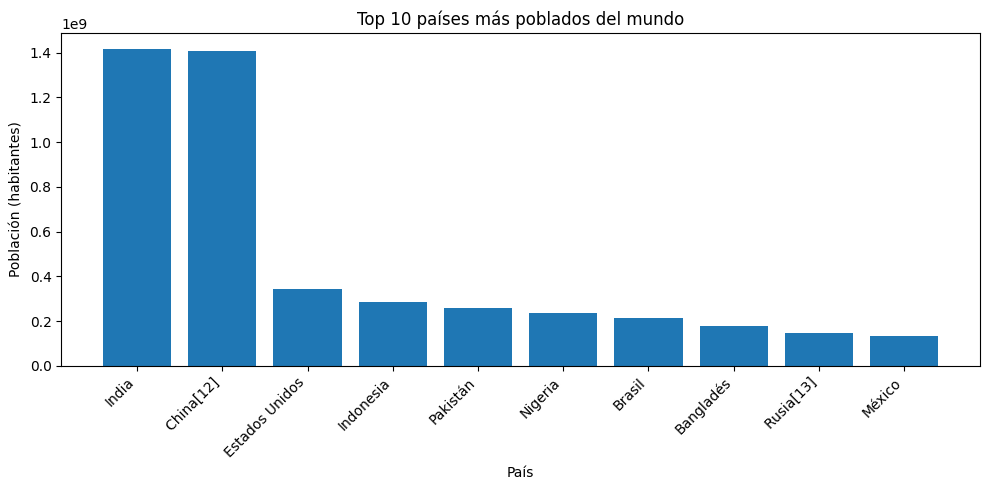

In [8]:
df_filtrado = df[~df["País"].str.contains("Mundo|Total", case=False, na=False)]
df_top10 = df_filtrado.sort_values("Población", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(df_top10["País"], df_top10["Población"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 países más poblados del mundo")
plt.xlabel("País")
plt.ylabel("Población (habitantes)")
plt.tight_layout()
plt.show()


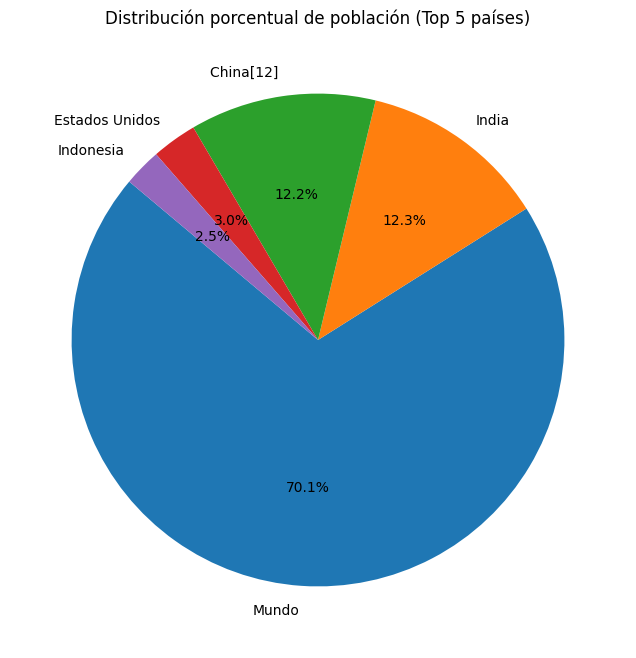

In [9]:
df_top5 = df.sort_values("Población", ascending=False).head(5)

plt.figure(figsize=(8, 8))
plt.pie(df_top5["Población"], labels=df_top5["País"], autopct="%1.1f%%", startangle=140)
plt.title("Distribución porcentual de población (Top 5 países)")
plt.show()


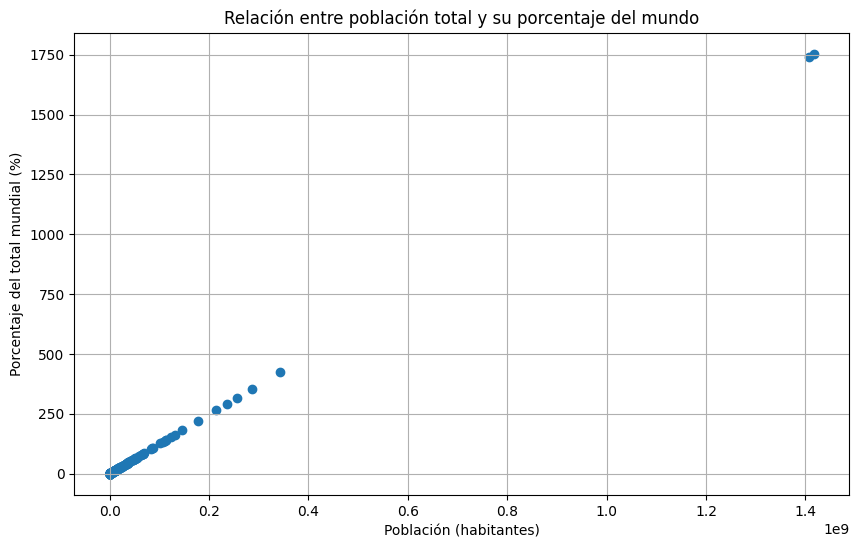

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtrado["Población"], df_filtrado["Porcentaje"])
plt.title("Relación entre población total y su porcentaje del mundo")
plt.xlabel("Población (habitantes)")
plt.ylabel("Porcentaje del total mundial (%)")
plt.grid(True)
plt.show()